In [1]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob

# MONAI Imports
import monai
from monai.transforms import (
    Compose, LoadImaged, ConvertToMultiChannelBasedOnBratsClassesd,
    CropForegroundd, RandSpatialCropd, RandFlipd, 
    NormalizeIntensityd, RandScaleIntensityd, RandShiftIntensityd,
    Activations, AsDiscrete
)
from monai.data import Dataset, DataLoader, decollate_batch
from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.utils import MetricReduction
from functools import partial
import time

2025-04-04 07:28:43.852477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 07:28:43.913275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 07:28:47.545747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set up environment
def setup_environment():
    """
    Setup training environment and print system information
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check and print device information
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
  
    return device

In [3]:
# Data Loading Function
def get_brats_files(data_dir):
    """
    Scan the data directory and collect BraTS image files.
    """
    train_data = []
    cases = sorted(glob.glob(os.path.join(data_dir, "BraTS-PED-*-000")))
    
    for case in cases:
        case_basename = os.path.basename(case)
        
        image_paths = [
            os.path.join(case, f"{case_basename}-t1c.nii.gz"),   # T1 contrast
            os.path.join(case, f"{case_basename}-t1n.nii.gz"),   # T1 non-contrast
            os.path.join(case, f"{case_basename}-t2f.nii.gz"),   # T2 FLAIR
            os.path.join(case, f"{case_basename}-t2w.nii.gz")    # T2 weighted
        ]
        
        label_path = os.path.join(case, f"{case_basename}-seg.nii.gz")
        
        if all(os.path.exists(path) for path in image_paths + [label_path]):
            train_data.append({
                "image": image_paths,
                "label": label_path
            })
    
    print(f"Total cases found: {len(train_data)}")
    return train_data

In [4]:
# Model Initialization Function
def initialize_model(device, roi=(128, 128, 128)):
    """
    Initialize SwinUNETR model for BraTS PEDs segmentation task
    """
    model = SwinUNETR(
        img_size=roi,
        in_channels=4,  # 4 input modalities
        out_channels=3,
        feature_size=48,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        dropout_path_rate=0.0,
        use_checkpoint=True,
    ).to(device)
    
    print("Model Initialized:")
    print(f"  Input size: {roi}")
    print(f"  Input channels: 4")
    print(f"  Output classes: 3")
    
    return model

In [5]:
# Training Components Setup
def setup_training_components(model, roi, sw_batch_size, max_epochs, device):
    """
    Setup training components for BraTS segmentation task
    """
    # Enable cuDNN benchmark mode
    torch.backends.cudnn.benchmark = True
    
    # Loss and Metrics
    dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
    dice_acc = DiceMetric(
        include_background=True,
        reduction=MetricReduction.MEAN_BATCH,
        get_not_nans=True
    )
    
    # Model Inference
    model_inferer = partial(
        sliding_window_inference,
        roi_size=roi,
        sw_batch_size=sw_batch_size,
        predictor=model,
        overlap=0.7,
    )
    
    # Optimizer and Scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.0008,
        weight_decay=1e-5
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=max_epochs
    )
    
    return {
        'dice_loss': dice_loss,
        'dice_acc': dice_acc,
        'model_inferer': model_inferer,
        'optimizer': optimizer,
        'scheduler': scheduler
    }

In [6]:
# Data Transforms
def get_transforms(roi=(128, 128, 128)):
    """
    Create training and validation transforms
    """
    train_transform = Compose([
        LoadImaged(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        CropForegroundd(
            keys=["image", "label"],
            source_key="image",
            k_divisible=roi
        ),
        RandSpatialCropd(
            keys=["image", "label"],
            roi_size=roi,
            random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0, channel_wise=True),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0, channel_wise=True),
    ])
    
    val_transform = Compose([
        LoadImaged(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ])
    
    return train_transform, val_transform

In [7]:
# Environment Setup
device = setup_environment()

Device: cuda


In [8]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def train_epoch(model, loader, optimizer, dice_loss, epoch, max_epochs, device):
    """
    Training epoch function with improved logging and error handling
    
    Args:
        model (torch.nn.Module): Model to train
        loader (DataLoader): Training data loader
        optimizer (torch.optim.Optimizer): Optimizer
        dice_loss (torch.nn.Module): Dice loss function
        epoch (int): Current epoch number
        max_epochs (int): Total number of epochs
        device (torch.device): Training device
    
    Returns:
        float: Average loss for the epoch
    """
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    
    # Post-processing transforms
    post_sigmoid = Activations(sigmoid=True)
    post_pred = AsDiscrete(threshold=0.5)
    
    try:
        for idx, batch_data in enumerate(loader):
            optimizer.zero_grad()  # Zero gradients before each batch
            
            data = batch_data["image"].to(device)
            target = batch_data["label"].to(device)
            
            # Forward pass
            logits = model(data)
            loss = dice_loss(logits, target)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update loss tracking
            run_loss.update(loss.item(), n=data.size(0))
            
            # Logging
            print(
                f"Train Epoch [{epoch}/{max_epochs}] [{idx}/{len(loader)}]",
                f"Loss: {run_loss.avg:.4f}",
                f"Time: {time.time() - start_time:.2f}s"
            )
            
            start_time = time.time()
    
    except Exception as e:
        print(f"Error during training epoch {epoch}: {e}")
        raise
    
    return run_loss.avg

In [10]:
def val_epoch(model, loader, dice_acc, model_inferer, epoch, max_epochs, device):
    """
    Validation epoch function with detailed metrics tracking
    
    Args:
        model (torch.nn.Module): Model to validate
        loader (DataLoader): Validation data loader
        dice_acc (DiceMetric): Dice accuracy metric
        model_inferer (callable): Sliding window inference function
        epoch (int): Current epoch number
        max_epochs (int): Total number of epochs
        device (torch.device): Validation device
    
    Returns:
        numpy.ndarray: Average Dice scores
    """
    model.eval()
    start_time = time.time()
    
    # Post-processing transforms
    post_sigmoid = Activations(sigmoid=True)
    post_pred = AsDiscrete(threshold=0.5)
    
    with torch.no_grad():
        try:
            for idx, batch_data in enumerate(loader):
                data = batch_data["image"].to(device)
                target = batch_data["label"].to(device)
                
                # Inference
                logits = model_inferer(data)
                
                # Decollate and post-process
                val_labels_list = decollate_batch(target)
                val_outputs_list = decollate_batch(logits)
                
                val_output_convert = [
                    post_pred(post_sigmoid(val_pred_tensor)) 
                    for val_pred_tensor in val_outputs_list
                ]
                
                # Reset and compute metrics
                dice_acc.reset()
                dice_acc(y_pred=val_output_convert, y=val_labels_list)
                dice_metric, not_nans = dice_acc.aggregate()
                
                # Assuming 3 classes: TC (Tumor Core), WT (Whole Tumor), ET (Enhancing Tumor)
                dice_tc, dice_wt, dice_et = dice_metric.cpu().numpy()
                
                # Logging
                print(
                    f"Val Epoch [{epoch}/{max_epochs}] [{idx}/{len(loader)}]",
                    f"Dice TC: {dice_tc:.4f}",
                    f"Dice WT: {dice_wt:.4f}",
                    f"Dice ET: {dice_et:.4f}",
                    f"Time: {time.time() - start_time:.2f}s"
                )
                
                start_time = time.time()
        
        except Exception as e:
            print(f"Error during validation epoch {epoch}: {e}")
            raise
    
    return dice_metric.cpu().numpy()

In [11]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    max_epochs,
    val_every=10,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
    checkpoint_dir='./checkpoints'
):
    """
    Training loop for brain tumor segmentation model
    
    Args:
        model (torch.nn.Module): Segmentation model
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        optimizer (torch.optim.Optimizer): Model optimizer
        loss_func (callable): Loss function
        acc_func (callable): Accuracy metric function
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler
        max_epochs (int): Total number of training epochs
        val_every (int, optional): Validation frequency. Defaults to 1.
        model_inferer (callable, optional): Model inference function
        start_epoch (int, optional): Epoch to start from. Defaults to 0.
        post_sigmoid (callable, optional): Post-processing sigmoid transform
        post_pred (callable, optional): Post-processing prediction transform
        checkpoint_dir (str, optional): Directory to save checkpoints
    
    Returns:
        tuple: Training metrics and results
    """
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Tracking metrics
    val_acc_max = 0.0
    dices_tc, dices_wt, dices_et = [], [], []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    
    try:
        for epoch in range(start_epoch, max_epochs):
            # Print current time and epoch
            print(time.ctime(), "Epoch:", epoch)
            epoch_time = time.time()
            
            # Training epoch
            train_loss = train_epoch(
                model=model,
                loader=train_loader,
                optimizer=optimizer,
                dice_loss=loss_func,
                epoch=epoch,
                max_epochs=max_epochs,  # Add this line
                device=next(model.parameters()).device  # Add this line
            )
            
            # Training epoch summary
            print(
                f"Final training {epoch}/{max_epochs - 1}",
                f"loss: {train_loss:.4f}",
                f"time {time.time() - epoch_time:.2f}s",
            )
            
            # Validation phase
            if (epoch + 1) % val_every == 0 or epoch == 0:
                # Track training metrics
                loss_epochs.append(train_loss)
                trains_epoch.append(int(epoch))
                
                # Validation time tracking
                epoch_time = time.time()
                
                # Run validation
                val_acc = val_epoch(
                    model,
                    val_loader,
                    epoch=epoch,
                    dice_acc=acc_func,
                    model_inferer=model_inferer,
                    max_epochs=max_epochs,
                    device=next(model.parameters()).device
                )
                
                # Extract validation metrics
                dice_tc = val_acc[0]
                dice_wt = val_acc[1]
                dice_et = val_acc[2]
                val_avg_acc = np.mean(val_acc)
                
                # Validation summary
                print(
                    f"Final validation stats {epoch}/{max_epochs - 1}",
                    f", dice_tc: {dice_tc}",
                    f", dice_wt: {dice_wt}",
                    f", dice_et: {dice_et}",
                    f", Dice_Avg: {val_avg_acc}",
                    f", time {time.time() - epoch_time:.2f}s",
                )
                
                # Track metrics
                dices_tc.append(dice_tc)
                dices_wt.append(dice_wt)
                dices_et.append(dice_et)
                dices_avg.append(val_avg_acc)
                
                # Model checkpointing
                if val_avg_acc > val_acc_max:
                    print(
                        f"New best model: {val_acc_max:.6f} --> {val_avg_acc:.6f}"
                    )
                    val_acc_max = val_avg_acc
                    
                    # Save best model checkpoint
                    save_checkpoint(
                        model,
                        epoch,
                        best_acc=val_acc_max,
                        checkpoint_dir=checkpoint_dir
                    )
                
                # Step learning rate scheduler
                scheduler.step()
    
    except Exception as e:
        print(f"Training interrupted: {e}")
        raise
    
    # Final training summary
    print(f"Training Finished! Best Accuracy: {val_acc_max}")
    
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [12]:
def save_checkpoint(
    model, 
    epoch, 
    best_acc, 
    checkpoint_dir='./checkpoints', 
    filename='best_model.pth'
):
    """
    Save model checkpoint
    
    Args:
        model (torch.nn.Module): Model to save
        epoch (int): Current epoch
        best_acc (float): Best validation accuracy
        checkpoint_dir (str, optional): Directory to save checkpoint
        filename (str, optional): Filename for checkpoint
    """
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Full path for checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'best_acc': best_acc
    }, checkpoint_path)
    
    print(f"Checkpoint saved: {checkpoint_path}")

In [13]:
# Training Execution Preparation
# Define post-processing transforms
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# Set initial start epoch
start_epoch = 0

# Ensure all required variables are defined from previous setup
DATA_DIR = r"BraTS-PEDs2024_Subset"
ROI = (128, 128, 128)
BATCH_SIZE = 1
SW_BATCH_SIZE = 2
MAX_EPOCHS = 100
FOLD = 1
 
# Recreate data loaders and other components
data_files = get_brats_files(DATA_DIR)
train_transform, val_transform = get_transforms(ROI)

# Create datasets and loaders
train_files = data_files[:int(0.8 * len(data_files))]
val_files = data_files[int(0.8 * len(data_files)):]

train_ds = Dataset(data=train_files, transform=train_transform)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_ds = Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# Reinitialize model, optimizer, etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = initialize_model(device, roi=ROI)

# Setup training components
training_components = setup_training_components(
    model, ROI, SW_BATCH_SIZE, MAX_EPOCHS, device
)

# Unpack training components
dice_loss = training_components['dice_loss']
dice_acc = training_components['dice_acc']
model_inferer = training_components['model_inferer']
optimizer = training_components['optimizer']
scheduler = training_components['scheduler']

# Main Training Execution
try:
    # Run trainer and unpack results
    (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    ) = trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_func=dice_loss,
        acc_func=dice_acc,
        scheduler=scheduler,
        max_epochs=MAX_EPOCHS,
        model_inferer=model_inferer,
        start_epoch=start_epoch,
        post_sigmoid=post_sigmoid,
        post_pred=post_pred,
    )
    
#     Print final results
    print(f"Training completed, best average Dice score: {val_acc_max:.4f}")

except Exception as e:
    print(f"Training failed with error: {e}")

Total cases found: 26


/home/u2/avikalsingh/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
/home/u2/avikalsingh/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Model Initialized:
  Input size: (128, 128, 128)
  Input channels: 4
  Output classes: 3
Fri Apr  4 07:28:53 2025 Epoch: 0


/home/u2/avikalsingh/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Train Epoch [0/100] [0/20] Loss: 0.9684 Time: 161.26s
Train Epoch [0/100] [1/20] Loss: 0.9842 Time: 1.76s
Train Epoch [0/100] [2/20] Loss: 0.9746 Time: 1.75s
Train Epoch [0/100] [3/20] Loss: 0.9786 Time: 1.75s
Train Epoch [0/100] [4/20] Loss: 0.9820 Time: 1.75s
Train Epoch [0/100] [5/20] Loss: 0.9822 Time: 1.75s
Train Epoch [0/100] [6/20] Loss: 0.9597 Time: 1.76s
Train Epoch [0/100] [7/20] Loss: 0.9613 Time: 1.75s
Train Epoch [0/100] [8/20] Loss: 0.9597 Time: 1.76s
Train Epoch [0/100] [9/20] Loss: 0.9527 Time: 1.75s
Train Epoch [0/100] [10/20] Loss: 0.9561 Time: 1.75s
Train Epoch [0/100] [11/20] Loss: 0.9597 Time: 1.75s
Train Epoch [0/100] [12/20] Loss: 0.9618 Time: 1.75s
Train Epoch [0/100] [13/20] Loss: 0.9631 Time: 1.99s
Train Epoch [0/100] [14/20] Loss: 0.9577 Time: 1.76s
Train Epoch [0/100] [15/20] Loss: 0.9528 Time: 1.75s
Train Epoch [0/100] [16/20] Loss: 0.9412 Time: 1.76s
Train Epoch [0/100] [17/20] Loss: 0.9436 Time: 1.75s
Train Epoch [0/100] [18/20] Loss: 0.9422 Time: 1.75s
T

In [14]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

train completed, best average dice: 0.3515 


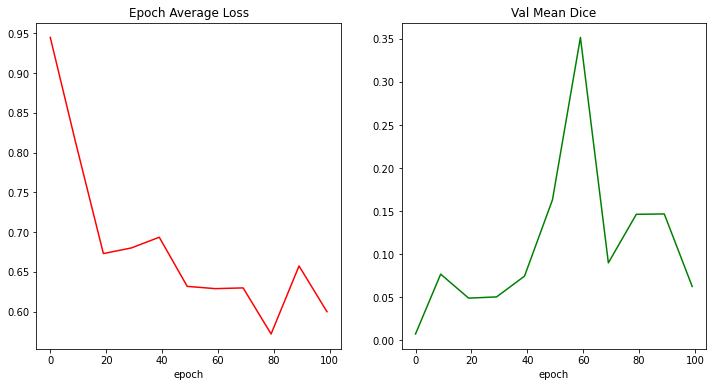

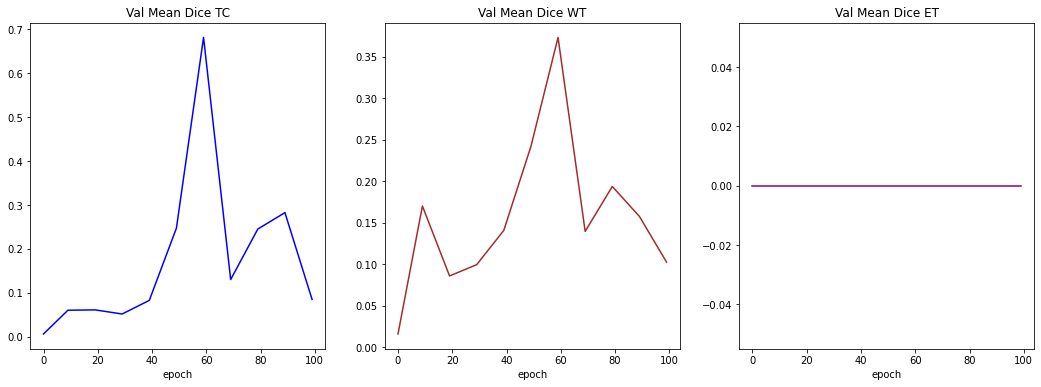

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()